In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


# Size stuff

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.996 0.    0.004] [1. 0. 0.] [1. 0. 0.]
[0.98  0.002 0.018] [0.998 0.002 0.   ] [0.998 0.002 0.   ]
[0.93  0.004 0.066] [0.996 0.004 0.   ] [0.98  0.004 0.016]
[0.872 0.004 0.124] [0.996 0.004 0.   ] [0.902 0.004 0.094]
[0.87 0.   0.13] [1. 0. 0.] [0.888 0.    0.112]
[0.91  0.004 0.086] [0.996 0.004 0.   ] [0.924 0.004 0.072]
[0.892 0.006 0.102] [0.994 0.006 0.   ] [0.9   0.004 0.096]
[0.914 0.012 0.074] [0.988 0.012 0.   ] [0.92  0.008 0.072]
[0.928 0.004 0.068] [0.99  0.004 0.006] [0.932 0.004 0.064]
[0.926 0.002 0.072] [0.966 0.002 0.032] [0.93  0.002 0.068]
[0.918 0.008 0.074] [0.936 0.008 0.056] [0.92  0.008 0.072]
[0.902 0.02  0.078] [0.912 0.02  0.068] [0.914 0.018 0.068]
[0.93  0.018 0.052] [0.93  0.018 0.052] [0.938 0.016 0.046]
[0.946 0.01  0.044] [0.946 0.01  0.044] [0.954 0.006 0.04 ]
[0.932 0.002 0.066] [0.932 0.002 0.066] [0.94  0.002 0.058]
[0.944 0.006 0.05 ] [0.944 0.006 0.05 ] [0.95  0.004 0.046]
[0.944 0.008 0.048] [0.944 0.008 0.04

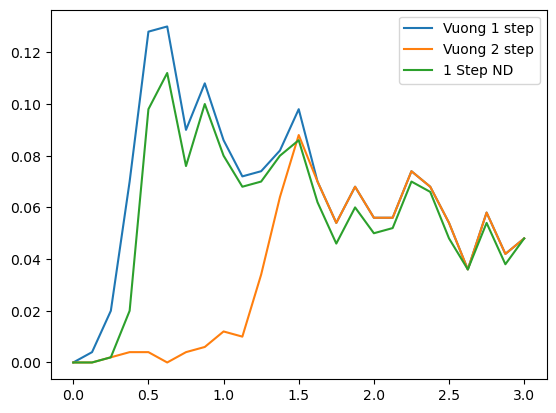

In [4]:
betas = np.linspace(0,3,25)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.978 0.    0.022] [1. 0. 0.] [1. 0. 0.]
[0.922 0.002 0.076] [0.998 0.002 0.   ] [1. 0. 0.]
[0.886 0.002 0.112] [0.998 0.002 0.   ] [1. 0. 0.]
[0.922 0.    0.078] [1. 0. 0.] [1. 0. 0.]
[0.902 0.008 0.09 ] [0.992 0.008 0.   ] [1. 0. 0.]
[0.898 0.006 0.096] [0.994 0.006 0.   ] [1. 0. 0.]
[0.908 0.006 0.086] [0.994 0.006 0.   ] [1. 0. 0.]
[0.916 0.006 0.078] [0.986 0.006 0.008] [1. 0. 0.]
[0.918 0.01  0.072] [0.958 0.01  0.032] [1. 0. 0.]
[0.946 0.008 0.046] [0.964 0.008 0.028] [1. 0. 0.]
[0.918 0.002 0.08 ] [0.922 0.002 0.076] [1. 0. 0.]
[0.932 0.008 0.06 ] [0.932 0.008 0.06 ] [1. 0. 0.]
[0.93  0.014 0.056] [0.93  0.014 0.056] [1. 0. 0.]
[0.928 0.014 0.058] [0.928 0.014 0.058] [1. 0. 0.]
[0.916 0.024 0.06 ] [0.916 0.024 0.06 ] [1. 0. 0.]
[0.946 0.008 0.046] [0.946 0.008 0.046] [1. 0. 0.]
[0.942 0.014 0.044] [0.942 0.014 0.044] [1. 0. 0.]
[0.934 0.008 0.058] [0.934 0.008 0.058] [1. 0. 0.]
[0.932 0.02  0.048] [0.932 0.02  0

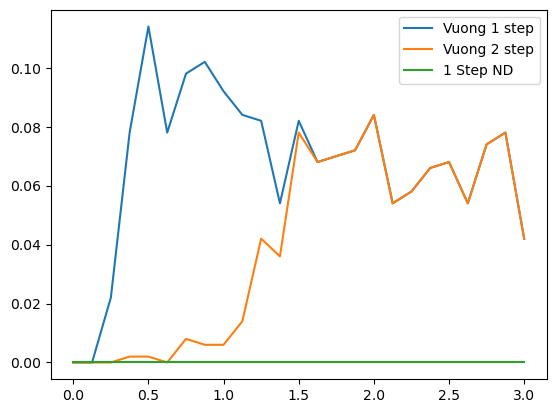

In [3]:
betas = np.linspace(0,3,25)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=200, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True,cstar0=1000)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()

# alternate DGP

In [5]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y


def setup_shi2(yn,xn,return_model=False,num_params=4):
    x1n,x2n = xn[:,0],xn[:,1:num_params]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    
    model1_deriv = OLS_loglike(yn,sm.add_constant(x1n))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    grad1 =  model1_deriv.score_obs(model1_fit.params)    
    hess1 = model1_deriv.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    params2 = (model2_fit.params)
    
    model2_deriv = OLS_loglike(yn,sm.add_constant(x2n))
    ll2 = model2_deriv.loglikeobs(model2_fit.params)
    grad2 =  model2_deriv.score_obs(model2_fit.params)    
    hess2 = model2_deriv.hessian(model2_fit.params)
    
    if return_model:
        return ll1,grad1,hess1,params1,model1,ll2,grad2,hess2,params2,model2
    return ll1,grad1,hess1,params1,ll2,grad2,hess2,params2

def gen_data2(nobs=1000, a=0.25, num_params=4):
    x = np.random.normal(scale=1., size=(nobs,1+num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*x[:,0] + a/np.sqrt(num_params)*x[:,1:num_params+1].sum(axis=1) + e
    return y,x,nobs

yn,xn,nobs = gen_data2()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi2(yn,xn,return_model=False,num_params=15)
print(grad1.shape,hess1.shape)

(1000, 2) (2, 2)


[0.918 0.    0.082] [0.992 0.    0.008] [1. 0. 0.]
[0.898 0.    0.102] [0.984 0.    0.016] [1. 0. 0.]
[0.896 0.006 0.098] [0.966 0.002 0.032] [0.992 0.    0.008]
[0.902 0.006 0.092] [0.918 0.006 0.076] [0.978 0.    0.022]
[0.926 0.008 0.066] [0.928 0.008 0.064] [0.978 0.002 0.02 ]
[0.924 0.016 0.06 ] [0.924 0.016 0.06 ] [0.98  0.002 0.018]
[0.934 0.018 0.048] [0.934 0.018 0.048] [0.978 0.01  0.012]
[0.948 0.008 0.044] [0.948 0.008 0.044] [0.976 0.004 0.02 ]
[0.948 0.02  0.032] [0.948 0.02  0.032] [0.982 0.008 0.01 ]
[0.922 0.036 0.042] [0.922 0.036 0.042] [0.972 0.02  0.008]
[0.942 0.02  0.038] [0.942 0.02  0.038] [0.98  0.006 0.014]
[0.926 0.028 0.046] [0.926 0.028 0.046] [0.974 0.01  0.016]
[0.928 0.032 0.04 ] [0.928 0.032 0.04 ] [0.982 0.008 0.01 ]
[0.946 0.038 0.016] [0.946 0.038 0.016] [0.974 0.016 0.01 ]
[0.944 0.026 0.03 ] [0.944 0.026 0.03 ] [0.99  0.006 0.004]
[0.954 0.026 0.02 ] [0.954 0.026 0.02 ] [0.978 0.012 0.01 ]
[0.948 0.036 0.016] [0.948 0.036 0.016] [0.988 0.006 0.006

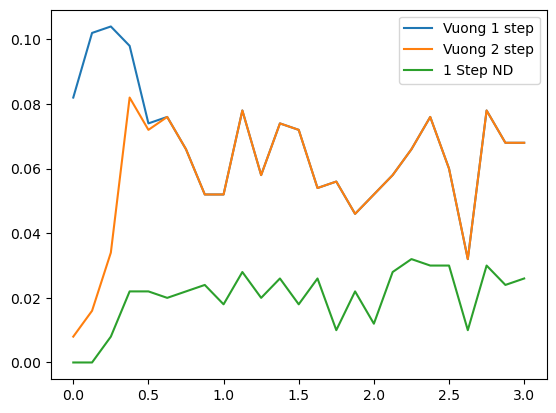

In [6]:
a = np.linspace(0,3,25)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi_ex,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()

[0.93 0.   0.07] [0.994 0.    0.006] [1. 0. 0.]
[0.916 0.    0.084] [0.99 0.   0.01] [1. 0. 0.]
[0.912 0.    0.088] [0.96 0.   0.04] [1. 0. 0.]
[0.928 0.004 0.068] [0.95  0.004 0.046] [1. 0. 0.]
[0.922 0.008 0.07 ] [0.926 0.008 0.066] [1. 0. 0.]
[0.938 0.016 0.046] [0.938 0.016 0.046] [1. 0. 0.]
[0.94 0.02 0.04] [0.94 0.02 0.04] [1. 0. 0.]
[0.932 0.024 0.044] [0.932 0.024 0.044] [1. 0. 0.]
[0.93 0.03 0.04] [0.93 0.03 0.04] [1. 0. 0.]
[0.96  0.014 0.026] [0.96  0.014 0.026] [1. 0. 0.]
[0.936 0.02  0.044] [0.936 0.02  0.044] [1. 0. 0.]
[0.948 0.032 0.02 ] [0.948 0.032 0.02 ] [1. 0. 0.]
[0.946 0.024 0.03 ] [0.946 0.024 0.03 ] [1. 0. 0.]
[0.938 0.034 0.028] [0.938 0.034 0.028] [1. 0. 0.]
[0.936 0.03  0.034] [0.936 0.03  0.034] [1. 0. 0.]
[0.924 0.044 0.032] [0.924 0.044 0.032] [1. 0. 0.]
[0.94 0.04 0.02] [0.94 0.04 0.02] [1. 0. 0.]
[0.944 0.032 0.024] [0.944 0.032 0.024] [1. 0. 0.]
[0.924 0.042 0.034] [0.924 0.042 0.034] [1. 0. 0.]
[0.932 0.038 0.03 ] [0.932 0.038 0.03 ] [1. 0. 0.]
[0.938 

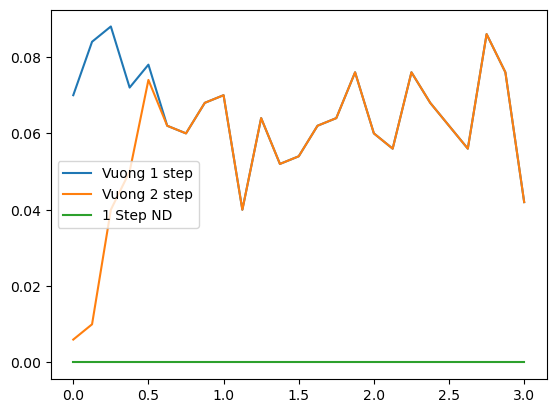

In [7]:
a = np.linspace(0,3,25)
results = []
num_params=9

for a1 in a:
    setup_shi_ex  = lambda yn,xn: setup_shi2(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data2(nobs=100, a=a1,  num_params=num_params)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi_ex,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True,cstar0=400)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()

# Power stuff

[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.998 0.    0.002] [1. 0. 0.] [1. 0. 0.]
[0.996 0.    0.004] [1. 0. 0.] [1. 0. 0.]
[0.964 0.    0.036] [1. 0. 0.] [0.998 0.    0.002]
[0.868 0.    0.132] [1. 0. 0.] [0.94 0.   0.06]
[0.74 0.   0.26] [1. 0. 0.] [0.85 0.   0.15]
[0.628 0.    0.372] [1. 0. 0.] [0.68 0.   0.32]
[0.498 0.    0.502] [1. 0. 0.] [0.552 0.    0.448]
[0.496 0.    0.504] [1. 0. 0.] [0.532 0.    0.468]
[0.314 0.    0.686] [1. 0. 0.] [0.34 0.   0.66]
[0.222 0.    0.778] [1. 0. 0.] [0.246 0.    0.754]
[0.18 0.   0.82] [1. 0. 0.] [0.2 0.  0.8]
[0.106 0.    0.894] [0.99 0.   0.01] [0.12 0.   0.88]
[0.102 0.    0.898] [0.992 0.    0.008] [0.106 0.    0.894]
[0.06 0.   0.94] [0.966 0.    0.034] [0.06 0.   0.94]
[0.04 0.   0.96] [0.944 0.    0.056] [0.046 0.    0.954]
[0.024 0.    0.976] [0.928 0.    0.072] [0.026 0.    0.974]
[0.006 0.    0.994] [0.928 0.    0.072] [0.008 0.    0.992]
[0.006 0.    0.994] [0.918 0.    0.082] [0.006 0.    0.994]
[0.004 0.    0.996] [0.9 0.  0.1] [0.004 0.

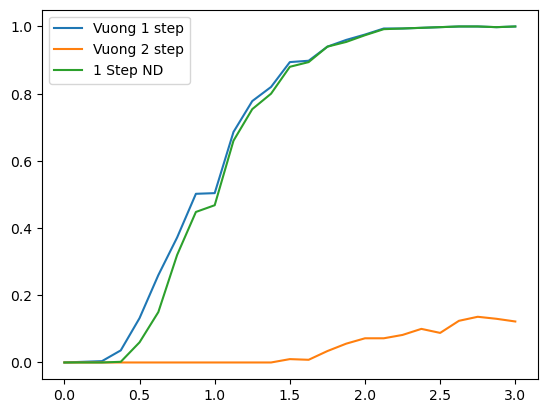

In [12]:

def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,25)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()

[0.998 0.    0.002] [1. 0. 0.] [1. 0. 0.]
[1. 0. 0.] [1. 0. 0.] [1. 0. 0.]
[0.998 0.    0.002] [1. 0. 0.] [1. 0. 0.]
[0.958 0.    0.042] [1. 0. 0.] [1. 0. 0.]
[0.876 0.    0.124] [1. 0. 0.] [1. 0. 0.]
[0.76 0.   0.24] [1. 0. 0.] [1. 0. 0.]
[0.676 0.    0.324] [1. 0. 0.] [1. 0. 0.]
[0.6 0.  0.4] [1. 0. 0.] [1. 0. 0.]
[0.45 0.   0.55] [1. 0. 0.] [1. 0. 0.]
[0.352 0.    0.648] [1. 0. 0.] [1. 0. 0.]
[0.244 0.    0.756] [0.998 0.    0.002] [1. 0. 0.]
[0.196 0.    0.804] [1. 0. 0.] [1. 0. 0.]
[0.118 0.    0.882] [0.992 0.    0.008] [1. 0. 0.]
[0.102 0.    0.898] [0.976 0.    0.024] [1. 0. 0.]
[0.052 0.    0.948] [0.974 0.    0.026] [1. 0. 0.]
[0.038 0.    0.962] [0.954 0.    0.046] [1. 0. 0.]
[0.01 0.   0.99] [0.946 0.    0.054] [1. 0. 0.]
[0.012 0.    0.988] [0.908 0.    0.092] [1. 0. 0.]
[0.006 0.    0.994] [0.93 0.   0.07] [1. 0. 0.]
[0. 0. 1.] [0.89 0.   0.11] [1. 0. 0.]
[0. 0. 1.] [0.872 0.    0.128] [1. 0. 0.]
[0. 0. 1.] [0.888 0.    0.112] [1. 0. 0.]
[0. 0. 1.] [0.854 0.    0.146] [1.

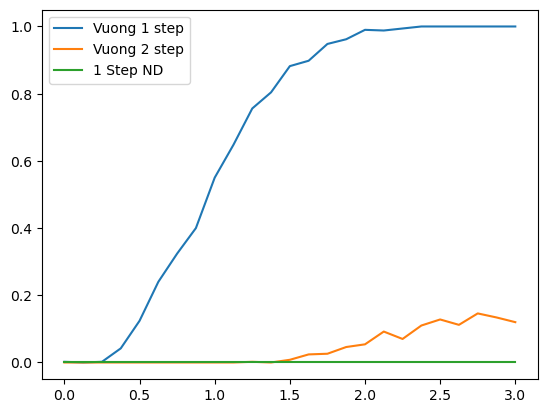

In [13]:

def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,25)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data3(nobs=100, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(500,gen_data_ex,setup_shi,trials=100,
                                          skip_boot=True,skip_shi=True,refinement_test=True,cstar0=400)
    reg,twostep, refine_test,boot1,boot2,boot3,shi, llr,std, omega = mc_out
    print(reg,twostep,refine_test)
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

results2 = np.array(results)
print(results2.shape)

plt.plot(betas,1-results2[:,0,0],label='Vuong 1 step')
plt.plot(betas,1-results2[:,1,0],label='Vuong 2 step')
plt.plot(betas,1-results2[:,2,0],label='1 Step ND')
#plt.plot(betas,1-results2[:,3,0],label='Shi (2015)')
plt.legend()
plt.show()